In [68]:
from cv2 import aruco
import cv2
import numpy as np
import matplotlib.pyplot as plt
import msgpack as mp
import msgpack_numpy as mpn
import os

from tqdm import tqdm
import csv
import pandas as pd
import polars as pl
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))
from support.pd_support import *

# from numba import njit
from datetime import datetime

from support.pd_support import *
from support.ar_calculations import *

from scipy.signal import savgol_filter

In [2]:
_pth = os.getcwd()
_pth = os.path.dirname(_pth)
_parent_folder = "cam_june_22_2023"
_calib_folder_name = "calibration_00"

_folder_name = "sk40_30_4_random_long_mocap_11"
# _folder_name = "board"

_base_pth = os.path.join(_pth,"recorded_data",_parent_folder)

_webcam_calib_folder = os.path.join(_pth,"recorded_data",_parent_folder,_calib_folder_name)
_webcam_calib_folder = os.path.join(_webcam_calib_folder)
_webcam_calib_pth = os.path.join( _webcam_calib_folder, "webcam_calibration.msgpack")

with open(_webcam_calib_pth, "rb") as f:
    webcam_calib = mp.Unpacker(f, object_hook=mpn.decode)
    _temp = next(webcam_calib)
    _webcam_cam_mat = _temp[0]
    _webcam_dist = _temp[1]

ar_lframe_pth = os.path.join(_webcam_calib_folder, "webcam_rotmat_4.msgpack")
with open(ar_lframe_pth, "rb") as f:
    ar_lframe = mp.Unpacker(f, object_hook=mpn.decode)
    _ar_lframe_rot = next(ar_lframe)
    _ar_lframe_org = next(ar_lframe)


In [3]:
ARUCO_PARAMETERS = aruco.DetectorParameters_create()
ARUCO_DICT = aruco.Dictionary_get(aruco.DICT_ARUCO_ORIGINAL)
markerLength = 0.04
markerSeparation = 0.01

board = aruco.GridBoard_create(
        markersX=1,
        markersY=1,
        markerLength=markerLength,
        markerSeparation=markerSeparation,
        dictionary=ARUCO_DICT)

In [4]:
# timestamp
ts = []
ts_pth = os.path.join(_base_pth, _folder_name, "webcam_timestamp.msgpack")
ts_file = open(ts_pth, "rb")
ts_unpacker = mp.Unpacker(ts_file, object_hook=mpn.decode)
for ts_data in ts_unpacker:
    ts.append(ts_data)

In [5]:
_video_pth = os.path.join(_base_pth,_folder_name,"webcam_color.msgpack")
_video_file = open(_video_pth, "rb")
_video_data = mp.Unpacker(_video_file, object_hook=mpn.decode)

default_ids = [0, 49, 80]

data = {"frame_id":[],"marker_ids":[], "corners":[], "tvec":[], "rvec":[]}

counter = 0

for _frame in tqdm(_video_data):

    shape = _frame.shape
    gray = cv2.cvtColor(_frame, cv2.COLOR_BGR2GRAY)
    corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, ARUCO_DICT, parameters=ARUCO_PARAMETERS)

    corners, ids, rejectedImgPoints, recoveredIds = aruco.refineDetectedMarkers(
        image = gray,
        board = board,
        detectedCorners = corners,
        detectedIds = ids,
        rejectedCorners = rejectedImgPoints,
        cameraMatrix = _webcam_cam_mat,
        distCoeffs = _webcam_dist)

    rotation_vectors, translation_vectors, _ = aruco.estimatePoseSingleMarkers(corners, 0.04, _webcam_cam_mat, _webcam_dist)

    if ids is None:
        data["frame_id"].append(counter)
        data["marker_ids"].append(None)
        data["corners"].append(None)
        data["tvec"].append(None)
        data["rvec"].append(None)

    if ids is not None:
        data["frame_id"].append(counter)
        data["marker_ids"].append(ids)
        data["corners"].append(corners)
        data["tvec"].append(translation_vectors)
        data["rvec"].append(rotation_vectors)

    counter+=1


_video_file.close()

0it [00:00, ?it/s]

1321it [00:12, 102.58it/s]


In [6]:
coordinate = {"0":{"x":[], "y":[], "z":[], "rx":[], "ry":[], "rz":[]},
              "49":{"x":[], "y":[], "z":[], "rx":[], "ry":[], "rz":[]},
              "80":{"x":[], "y":[], "z":[], "rx":[], "ry":[], "rz":[]}}

doesnt_exist = [] # list of ids that doesnt exist in a frame

for i in range(len(data["frame_id"])):
    if data["marker_ids"][i] is not None:

        if default_ids[0] not in data["marker_ids"][i]:
            doesnt_exist.append(default_ids[0])
        if default_ids[1] not in data["marker_ids"][i]:
            doesnt_exist.append(default_ids[1])
        if default_ids[2] not in data["marker_ids"][i]:
            doesnt_exist.append(default_ids[2])

        for j in range(len(data["marker_ids"][i])):
            if data["marker_ids"][i][j] in default_ids:
                coordinate[str(data["marker_ids"][i][j][0])]["x"].append(data["tvec"][i][j][0][0])
                coordinate[str(data["marker_ids"][i][j][0])]["y"].append(data["tvec"][i][j][0][1])
                coordinate[str(data["marker_ids"][i][j][0])]["z"].append(data["tvec"][i][j][0][2])
                coordinate[str(data["marker_ids"][i][j][0])]["rx"].append(data["rvec"][i][j][0][0])
                coordinate[str(data["marker_ids"][i][j][0])]["ry"].append(data["rvec"][i][j][0][1])
                coordinate[str(data["marker_ids"][i][j][0])]["rz"].append(data["rvec"][i][j][0][2])
        for k in doesnt_exist:
            coordinate[str(k)]["x"].append(np.nan)
            coordinate[str(k)]["y"].append(np.nan)
            coordinate[str(k)]["z"].append(np.nan)
            coordinate[str(k)]["rx"].append(np.nan)
            coordinate[str(k)]["ry"].append(np.nan)
            coordinate[str(k)]["rz"].append(np.nan)
        doesnt_exist = []
    else:
        for k in default_ids:
            coordinate[str(k)]["x"].append(np.nan)
            coordinate[str(k)]["y"].append(np.nan)
            coordinate[str(k)]["z"].append(np.nan)
            coordinate[str(k)]["rx"].append(np.nan)
            coordinate[str(k)]["ry"].append(np.nan)
            coordinate[str(k)]["rz"].append(np.nan)

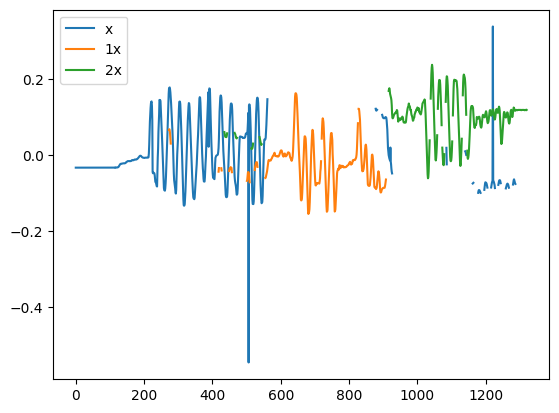

In [7]:
plt.plot(coordinate["0"]["x"], label="x")
plt.plot(coordinate["49"]["x"], label="1x")
plt.plot(coordinate["80"]["x"], label="2x")
plt.legend()

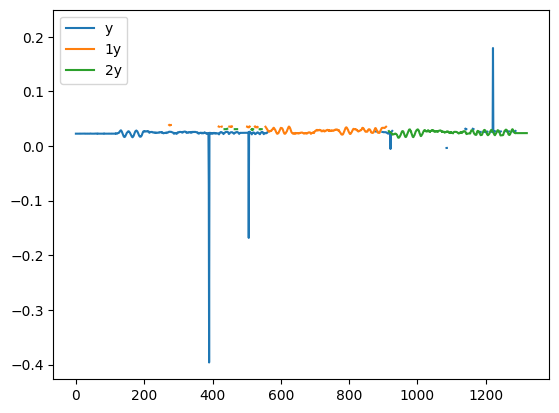

In [8]:
plt.plot(coordinate["0"]["y"], label="y")
plt.plot(coordinate["49"]["y"], label="1y")
plt.plot(coordinate["80"]["y"], label="2y")
plt.legend()

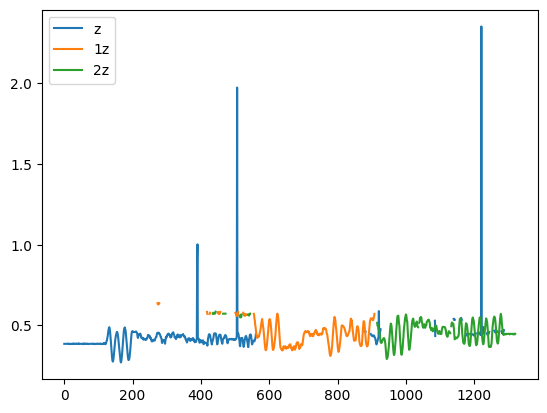

In [9]:
plt.plot(coordinate["0"]["z"], label="z")
plt.plot(coordinate["49"]["z"], label="1z")
plt.plot(coordinate["80"]["z"], label="2z")
plt.legend()

In [10]:
df_0 = pd.DataFrame({"x":coordinate["0"]["x"], "y":coordinate["0"]["y"], "z":coordinate["0"]["z"]})
df_0 = pl.from_pandas(df_0)

tcoor_0 = {"x":[], "y":[], "z":[]}
for i in range(len(coordinate["0"]["x"])):
    val = _ar_lframe_rot.T @ (df_0[i].to_numpy().reshape(3,1) - _ar_lframe_org)

    if val is None:
        x = np.nan
        y = np.nan
        z = np.nan
    else:
        x = val[0][0]
        y = val[1][0]
        z = val[2][0]
    tcoor_0["x"].append(x)
    tcoor_0["y"].append(y)
    tcoor_0["z"].append(z)

df_49 = pd.DataFrame({"x":coordinate["49"]["x"], "y":coordinate["49"]["y"], "z":coordinate["49"]["z"]})
df_49 = pl.from_pandas(df_49)

tcoor_49 = {"x":[], "y":[], "z":[]}
for i in range(len(coordinate["49"]["x"])):
    val = _ar_lframe_rot.T @ (df_49[i].to_numpy().reshape(3,1) - _ar_lframe_org)

    if val is None:
        x = np.nan
        y = np.nan
        z = np.nan
    else:
        x = val[0][0]
        y = val[1][0]
        z = val[2][0]
    tcoor_49["x"].append(x)
    tcoor_49["y"].append(y)
    tcoor_49["z"].append(z)

df_80 = pd.DataFrame({"x":coordinate["80"]["x"], "y":coordinate["80"]["y"], "z":coordinate["80"]["z"]})
df_80 = pl.from_pandas(df_80)

tcoor_80 = {"x":[], "y":[], "z":[]}
for i in range(len(coordinate["80"]["x"])):
    val = _ar_lframe_rot.T @ (df_80[i].to_numpy().reshape(3,1) - _ar_lframe_org)

    if val is None:
        x = np.nan
        y = np.nan
        z = np.nan
    else:
        x = val[0][0]
        y = val[1][0]
        z = val[2][0]
    tcoor_80["x"].append(x)
    tcoor_80["y"].append(y)
    tcoor_80["z"].append(z)

In [11]:
tcoor_df_0 = pd.DataFrame.from_dict(tcoor_0)
tcoor_df_49 = pd.DataFrame.from_dict(tcoor_49)
tcoor_df_80 = pd.DataFrame.from_dict(tcoor_80)

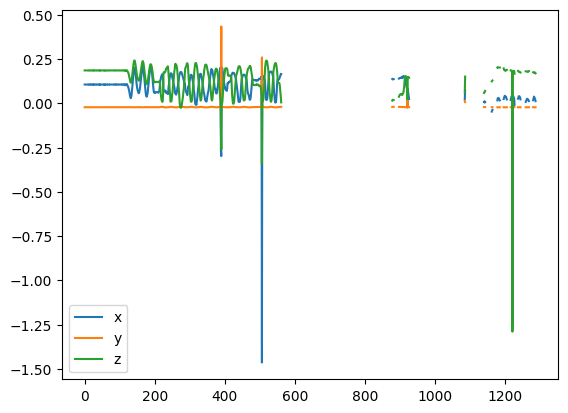

In [12]:
plt.plot(tcoor_0["x"], label="x")
plt.plot(tcoor_0["y"], label="y")
plt.plot(tcoor_0["z"], label="z")
plt.legend()

In [13]:
_mocap_pth = os.path.join(os.path.dirname(os.path.dirname(_video_pth)), "sk40", f"{_folder_name}.csv")
_mocap_df, st_time = read_rigid_body_csv(_mocap_pth)
_mocap_df = add_datetime_col(_mocap_df, st_time, "seconds")

In [14]:
_om = get_rb_marker_name(4)
_xm = get_rb_marker_name(1)
_zm = get_rb_marker_name(2)

In [15]:
"""
checking position
defining initial frame of reference
"""

xvec = [_mocap_df[_xm["x"]].iloc[0], _mocap_df[_xm["y"]].iloc[0], _mocap_df[_xm["z"]].iloc[0]]
xvec = np.array(xvec).reshape(3,1)

zvec = [_mocap_df[_zm["x"]].iloc[0], _mocap_df[_zm["y"]].iloc[0], _mocap_df[_zm["z"]].iloc[0]]
zvec = np.array(zvec).reshape(3,1)

org = [_mocap_df[_om["x"]].iloc[0], _mocap_df[_om["y"]].iloc[0], _mocap_df[_om["z"]].iloc[0]]
org = np.array(org).reshape(3,1)

v1 = xvec - org  # v1
v2 = zvec - org  # v2

vxnorm = v1 / np.linalg.norm(v1)

vzcap = v2 - (vxnorm.T @ v2) * vxnorm
vznorm = vzcap / np.linalg.norm(vzcap)

vynorm = np.cross(vznorm.T[0], vxnorm.T[0]).reshape(3, 1)
rotMat = np.hstack((vxnorm, vynorm, vznorm)) # rotation matrix

In [16]:
# @njit
def apply_rot_mat(mc_val, rotMat, org):
    return (rotMat.T @ (mc_val - org)).T[0]

In [17]:
# This cell is optimized to run faster using polars
_mc_df = _mocap_df[["time", _om["x"], _om["y"], _om["z"]]].copy()
_mc_df = _mc_df.rename(columns={_om["x"]: "x", _om["y"]: "y", _om["z"]: "z"})
# _mc_df = _mc_df.astype({"x": np.float64, "y": np.float64, "z": np.float64})

_mc_pl_df = pl.from_pandas(_mc_df)

my_dict = {"x":[],"y":[],"z":[]}

for i in tqdm(range(len(_mc_df))):
    _x, _y, _z = apply_rot_mat(_mc_pl_df[i, 1:].to_numpy().T, rotMat, org)
    my_dict["x"].append(_x)
    my_dict["y"].append(_y)
    my_dict["z"].append(_z)	

_mc_df["x"] = my_dict["x"]
_mc_df["y"] = my_dict["y"]
_mc_df["z"] = my_dict["z"]

100%|██████████| 13679/13679 [00:02<00:00, 6660.47it/s]


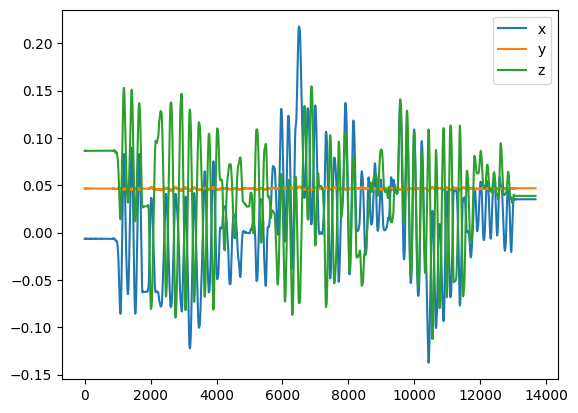

In [18]:
plt.plot(_mocap_df[_om["x"]], label="x")
plt.plot(_mocap_df[_om["y"]], label="y")
plt.plot(_mocap_df[_om["z"]], label="z")
plt.legend()

In [19]:
from ultralytics import YOLO

In [20]:
_model_name = "multi_114e_lp.pt"
_model_pth = os.path.join(os.getcwd(), "..", "models_save", _model_name)
model = YOLO(_model_pth)

In [21]:
_video_pth = os.path.join(_base_pth,_folder_name,"webcam_color.msgpack")
_video_file = open(_video_pth, "rb")
_video_data = mp.Unpacker(_video_file, object_hook=mpn.decode)

default_ids = [0, 49, 80]

data_ml = {"frame_id":[],"marker_ids":[], "corners":[], "tvec":[], "rvec":[]}

counter = 0
val = None

ids = None
modelcorners = None
translation_vectors = None
rotation_vectors = None

for _frame in tqdm(_video_data):

    shape = _frame.shape
    result = model(_frame, verbose=False)[0]  
    modelcorners = []
    for _keys in result.keypoints.data:
        # print(_keys)
        modelcorners.append(_keys[0:4].cpu().numpy())
    modelcorners = np.array(modelcorners)

    if len(result.boxes.cls.cpu().numpy()) != 0: # if there are any detections else None
        _idx = result.boxes.cls.cpu().numpy()
        ids = []
        for i in _idx:
            match i:
                case 0:
                    ids.append([0])
                case 1:
                    ids.append([49])
                case 2:
                    ids.append([80])
        ids = np.array(ids, dtype=np.int32)
    else:
        ids = None

    if len(modelcorners) != 0: # if there are any detections else skip

        try:
            rotation_vectors, translation_vectors, _ = aruco.estimatePoseSingleMarkers(modelcorners, 0.04, _webcam_cam_mat, _webcam_dist)
        except:
            ids = None

    if ids is None:
        data_ml["frame_id"].append(counter)
        data_ml["marker_ids"].append(None)
        data_ml["corners"].append(None)
        data_ml["tvec"].append(None)
        data_ml["rvec"].append(None)

    else:
        data_ml["frame_id"].append(counter)
        data_ml["marker_ids"].append(ids)
        data_ml["corners"].append(modelcorners)
        data_ml["tvec"].append(translation_vectors)
        data_ml["rvec"].append(rotation_vectors)

    counter+=1
    # break


_video_file.close()

1321it [00:25, 51.92it/s] 


In [22]:
coordinate_ml = {"0":{"x":[], "y":[], "z":[], "rx":[], "ry":[], "rz":[]},
              "49":{"x":[], "y":[], "z":[], "rx":[], "ry":[], "rz":[]},
              "80":{"x":[], "y":[], "z":[], "rx":[], "ry":[], "rz":[]}}

doesnt_exist = [] # list of ids that doesnt exist in a frame
default_ids = [0, 49, 80]

for i in range(len(data_ml["frame_id"])):
    if data_ml["marker_ids"][i] is not None:

        if default_ids[0] not in data_ml["marker_ids"][i]:
            doesnt_exist.append(default_ids[0])
        if default_ids[1] not in data_ml["marker_ids"][i]:
            doesnt_exist.append(default_ids[1])
        if default_ids[2] not in data_ml["marker_ids"][i]:
            doesnt_exist.append(default_ids[2])

        for j in range(len(data_ml["marker_ids"][i])):
            if data_ml["marker_ids"][i][j] in default_ids:
                coordinate_ml[str(data_ml["marker_ids"][i][j][0])]["x"].append( data_ml["tvec"][i][j][0][0])
                coordinate_ml[str(data_ml["marker_ids"][i][j][0])]["y"].append( data_ml["tvec"][i][j][0][1])
                coordinate_ml[str(data_ml["marker_ids"][i][j][0])]["z"].append( data_ml["tvec"][i][j][0][2])
                coordinate_ml[str(data_ml["marker_ids"][i][j][0])]["rx"].append(data_ml["rvec"][i][j][0][0])
                coordinate_ml[str(data_ml["marker_ids"][i][j][0])]["ry"].append(data_ml["rvec"][i][j][0][1])
                coordinate_ml[str(data_ml["marker_ids"][i][j][0])]["rz"].append(data_ml["rvec"][i][j][0][2])
        for k in doesnt_exist:
            coordinate_ml[str(k)]["x"].append(np.nan)
            coordinate_ml[str(k)]["y"].append(np.nan)
            coordinate_ml[str(k)]["z"].append(np.nan)
            coordinate_ml[str(k)]["rx"].append(np.nan)
            coordinate_ml[str(k)]["ry"].append(np.nan)
            coordinate_ml[str(k)]["rz"].append(np.nan)
        doesnt_exist = []
    else:
        for k in default_ids:
            coordinate_ml[str(k)]["x"].append(np.nan)
            coordinate_ml[str(k)]["y"].append(np.nan)
            coordinate_ml[str(k)]["z"].append(np.nan)
            coordinate_ml[str(k)]["rx"].append(np.nan)
            coordinate_ml[str(k)]["ry"].append(np.nan)
            coordinate_ml[str(k)]["rz"].append(np.nan)

In [70]:
filter_size = 11
filter_order = 3

filter_0_df = pl.DataFrame(coordinate_ml["0"])
filter_49_df = pl.DataFrame(coordinate_ml["49"])
filter_80_df = pl.DataFrame(coordinate_ml["80"])

# apply savgol filter for columns rx, ry, rz

filter_0_df = filter_0_df.with_columns([
                                pl.col("rx").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode(),
                                pl.col("ry").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode(),
                                pl.col("rz").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode()
                            ])

filter_49_df = filter_49_df.with_columns([
                                pl.col("rx").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode(),
                                pl.col("ry").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode(),
                                pl.col("rz").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode()
                                ])

filter_80_df = filter_80_df.with_columns([
                                pl.col("rx").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode(),
                                pl.col("ry").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode(),
                                pl.col("rz").map(lambda x: savgol_filter(x.to_numpy(), filter_size, filter_order)).explode()
                                ])

In [71]:
rmat = []
for i in range(len(coordinate_ml["0"]["x"])):
    rotation_vectors = np.array([coordinate_ml["0"]["rx"][i], coordinate_ml["0"]["ry"][i], coordinate_ml["0"]["rz"][i]])
    rotation_matrix = cv2.Rodrigues(rotation_vectors)[0]
    rmat.append(rotation_matrix)

rmat_49 = []
for i in range(len(coordinate_ml["49"]["x"])):
    rotation_vectors = np.array([coordinate_ml["49"]["rx"][i], coordinate_ml["49"]["ry"][i], coordinate_ml["49"]["rz"][i]])
    rotation_matrix = cv2.Rodrigues(rotation_vectors)[0]
    rmat_49.append(rotation_matrix)

rmat_80 = []
for i in range(len(coordinate_ml["80"]["x"])):
    rotation_vectors = np.array([coordinate_ml["80"]["rx"][i], coordinate_ml["80"]["ry"][i], coordinate_ml["80"]["rz"][i]])
    rotation_matrix = cv2.Rodrigues(rotation_vectors)[0]
    rmat_80.append(rotation_matrix)

Orthonormalizing rmat

In [25]:
# orthonormalizing rmat
orthormat = np.linalg.qr(rmat)[0]

In [26]:
print(len(coordinate_ml["0"]["x"]), len(coordinate_ml["49"]["y"]), len(coordinate_ml["80"]["z"]), len(data_ml["frame_id"]))

1322 1321 1321 1321


In [27]:
df_0_ml = pl.DataFrame(coordinate_ml["0"])
df_49_ml = pl.DataFrame(coordinate_ml["49"])
df_80_ml = pl.DataFrame(coordinate_ml["80"])

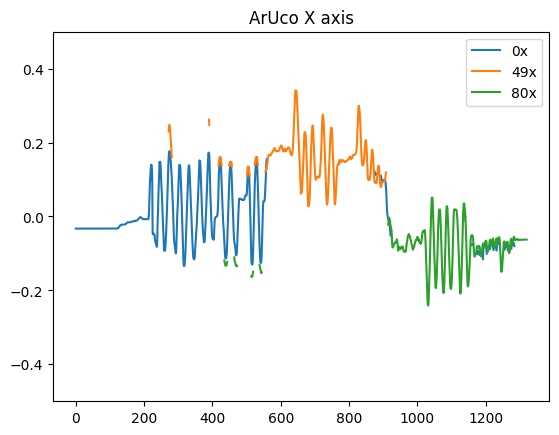

In [28]:
plt.plot(df_0_ml["x"], label="0x")
plt.plot(df_49_ml["x"] + 0.18, label="49x")
plt.plot(df_80_ml["x"] - 0.18, label="80x")
plt.ylim(-0.5, 0.5)
plt.title("ArUco X axis")
plt.legend()

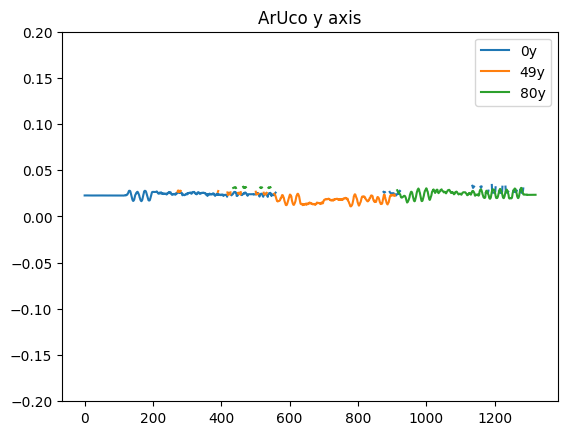

In [29]:
plt.plot(df_0_ml["y"], label="0y")
plt.plot(df_49_ml["y"] - 0.01, label="49y")
plt.plot(df_80_ml["y"], label="80y")
plt.ylim(-0.2, 0.2)
plt.title("ArUco y axis")
plt.legend()


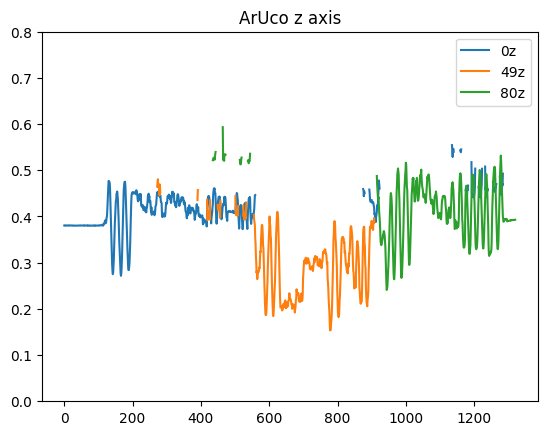

In [30]:
plt.plot(df_0_ml["z"], label="0z")
plt.plot(df_49_ml["z"] - 0.15, label="49z")
plt.plot(df_80_ml["z"] - 0.05, label="80z")
plt.ylim(0, 0.8)
plt.title("ArUco z axis")
plt.legend()

In [31]:
translation_correction = np.array([0.045, -0.05, 0.045]).reshape(3, 1)

In [32]:
if type(df_0_ml) is not pl.DataFrame:
    df_0_ml = pl.from_pandas(df_0_ml)

tcoor_0_ml = {"x":[], "y":[], "z":[]}
for i in range(len(coordinate_ml["49"]["x"])):
    # val = (_ar_lframe_rot.T @ (df_0_ml[["x", "y", "z"]][i].to_numpy().reshape(3,1) - _ar_lframe_org)) - translation_correction
    val = (orthormat[0].T @ (df_0_ml[["x", "y", "z"]][i].to_numpy().reshape(3,1) - df_0_ml[['x', 'y', 'z']][0].to_numpy().reshape(3,1))) 

    if val is None:
        x = np.nan
        y = np.nan
        z = np.nan
    else:
        x = val[0][0]
        y = val[1][0]
        z = val[2][0]
    tcoor_0_ml["x"].append(x)
    tcoor_0_ml["y"].append(y)
    tcoor_0_ml["z"].append(z)

if type(df_49_ml) is not pl.DataFrame:
    df_49_ml = pl.from_pandas(df_49_ml)

tcoor_49_ml = {"x":[], "y":[], "z":[]}
for i in range(len(coordinate_ml["49"]["x"])):
    # val = (_ar_lframe_rot.T @ (df_49_ml[["x", "y", "z"]][i].to_numpy().reshape(3,1) - _ar_lframe_org)) - translation_correction
    val = (orthormat[0].T @ (df_49_ml[["x", "y", "z"]][i].to_numpy().reshape(3,1))- df_0_ml[['x', 'y', 'z']][0].to_numpy().reshape(3,1))

    if val is None:
        x = np.nan
        y = np.nan
        z = np.nan
    else:
        x = val[0][0]
        y = val[1][0]
        z = val[2][0]
    tcoor_49_ml["x"].append(x)
    tcoor_49_ml["y"].append(y)
    tcoor_49_ml["z"].append(z)

if type(df_80_ml) is not pl.DataFrame:
    df_49_ml = pl.from_pandas(df_80_ml)

    
tcoor_80_ml = {"x":[], "y":[], "z":[]}
for i in range(len(coordinate_ml["49"]["x"])):
    # val = (_ar_lframe_rot.T @ (df_80_ml[["x", "y", "z"]][i].to_numpy().reshape(3,1) - _ar_lframe_org)) - translation_correction
    val = (orthormat[0].T @ (df_80_ml[["x", "y", "z"]][i].to_numpy().reshape(3,1))- df_0_ml[['x', 'y', 'z']][0].to_numpy().reshape(3,1)) 

    if val is None:
        x = np.nan
        y = np.nan
        z = np.nan
    else:
        x = val[0][0]
        y = val[1][0]
        z = val[2][0]
    tcoor_80_ml["x"].append(x)
    tcoor_80_ml["y"].append(y)
    tcoor_80_ml["z"].append(z)

In [33]:

ts_df = pd.DataFrame({"ts":ts})
ts_df["ts"] = pd.to_datetime(ts_df["ts"])

ar_df = pl.DataFrame({"time":ts,"x":tcoor_0_ml["x"], "y":tcoor_0_ml["y"], "z":tcoor_0_ml["z"]})
ar_df_49 = pl.DataFrame({"time":ts,"x":tcoor_49_ml["x"], "y":tcoor_49_ml["y"], "z":tcoor_49_ml["z"]})
ar_df_80 = pl.DataFrame({"time":ts,"x":tcoor_80_ml["x"], "y":tcoor_80_ml["y"], "z":tcoor_80_ml["z"]})

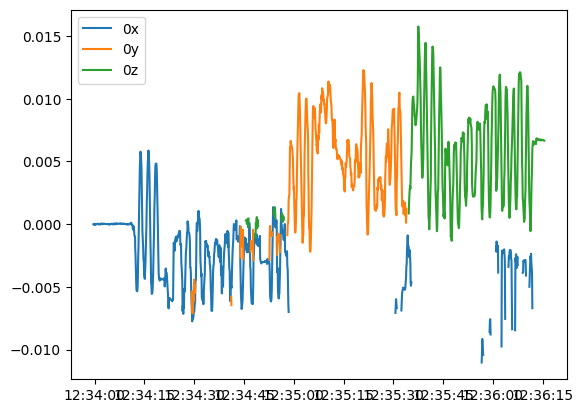

In [34]:
plt.plot(ts_df["ts"], np.array(tcoor_0_ml["x"]), label="0x")
plt.plot(ts_df["ts"], np.array(tcoor_49_ml["x"]), label="0y")
plt.plot(ts_df["ts"], np.array(tcoor_80_ml["x"]), label="0z")

# plt.plot(_mocap_df["time"], _mocap_df[_om["x"]], label="x")
# plt.plot(_mocap_df["time"], _mocap_df[_om["y"]], label="y")
# plt.plot(_mocap_df["time"], _mocap_df[_om["z"]], label="z")

plt.legend()

In [35]:
diff = -np.array([_mocap_df[_om["x"]][0]  - tcoor_0_ml["x"][0], _mocap_df[_om["y"]][0]- tcoor_0_ml["y"][0], _mocap_df[_om["z"]][0]- tcoor_0_ml["z"][0]])
print(diff)
print(diff.reshape(3,1))

[   0.006574   -0.046486   -0.086316]
[[   0.006574]
 [  -0.046486]
 [  -0.086316]]


In [36]:
print("length of the vector",np.linalg.norm(diff.reshape(3,1)))

length of the vector 0.09825791330981948


Bringing to skateboard frame

In [37]:
"""
checking position
defining initial frame of reference
"""

xvec = [_mocap_df[_xm["x"]].iloc[0], _mocap_df[_xm["y"]].iloc[0], _mocap_df[_xm["z"]].iloc[0]]
xvec = np.array(xvec).reshape(3,1)

zvec = [_mocap_df[_zm["x"]].iloc[0], _mocap_df[_zm["y"]].iloc[0], _mocap_df[_zm["z"]].iloc[0]]
zvec = np.array(zvec).reshape(3,1)

org = [_mocap_df[_om["x"]].iloc[0], _mocap_df[_om["y"]].iloc[0], _mocap_df[_om["z"]].iloc[0]]
org = np.array(org).reshape(3,1)

v1 = xvec - org  # v1
v2 = zvec - org  # v2

vxnorm = v1 / np.linalg.norm(v1)

vzcap = v2 - (vxnorm.T @ v2) * vxnorm
vznorm = vzcap / np.linalg.norm(vzcap)

vynorm = np.cross(vznorm.T[0], vxnorm.T[0]).reshape(3, 1)
rotMat = np.hstack((vxnorm, vynorm, vznorm)) # rotation matrix

# @njit
def apply_rot_mat(mc_val, rotMat, org):
    return (rotMat.T @ (mc_val - org)).T[0]

In [38]:
# This cell is optimized to run faster using polars
_mc_df = _mocap_df[["time", _om["x"], _om["y"], _om["z"]]].copy()
_mc_df = _mc_df.rename(columns={_om["x"]: "x", _om["y"]: "y", _om["z"]: "z"})
# _mc_df = _mc_df.astype({"x": np.float64, "y": np.float64, "z": np.float64})

_mc_pl_df = pl.from_pandas(_mc_df)

my_dict = {"x":[],"y":[],"z":[]}

for i in tqdm(range(len(_mc_df))):
    _x, _y, _z = apply_rot_mat(_mc_pl_df[i, 1:].to_numpy().T, rotMat, org)
    my_dict["x"].append(_x)
    my_dict["y"].append(_y)
    my_dict["z"].append(_z)	

_mc_df["x"] = my_dict["x"]
_mc_df["y"] = my_dict["y"]
_mc_df["z"] = my_dict["z"]

100%|██████████| 13679/13679 [00:01<00:00, 9379.63it/s]


In [97]:
# This cell is optimized to run faster using polars

# calculate rotation matrix from xvec, zvec, org
_m_df = _mocap_df.copy()
_m_df = pl.from_pandas(_m_df)

_rotmat_i = []
for i in tqdm(range(len(_m_df))):
    
    _x_vec = _m_df[[_xm["x"], _xm["y"], _xm["z"]]][i, :].to_numpy().T
    _org = _m_df[[_om["x"], _om["y"], _om["z"]]][i, :].to_numpy().T
    _z_vec = _m_df[[_zm["x"], _zm["y"], _zm["z"]]][i, :].to_numpy().T

    _rotmat_i.append(calculate_rotmat(_x_vec, _z_vec, _org))
# calculating del rotmat for mc
_del_r = []
for i in tqdm(range(len(_rotmat_i))):
    _del_r.append(_rotmat_i[i].T@_rotmat_i[0])

# calculating angle for mc
_theta_x = []
_theta_y = []
_theta_z = []

for i in tqdm(_del_r):
    _theta_x.append(np.arctan2(i[2,1], i[2,2]))
    _theta_y.append(np.arctan2(-i[2,0], np.sqrt(i[2,1]**2 + i[2,2]**2)))
    _theta_z.append(np.arctan2(i[1,0], i[0,0]))
    
_theta_x = np.array(_theta_x)
_theta_y = np.array(_theta_y)
_theta_z = np.array(_theta_z)

# converting them to degrees
_theta_x = np.rad2deg(_theta_x)
_theta_y = np.rad2deg(_theta_y)
_theta_z = np.rad2deg(_theta_z)

  0%|          | 0/13679 [00:00<?, ?it/s]

100%|██████████| 13679/13679 [00:00<00:00, 186602.98it/s]


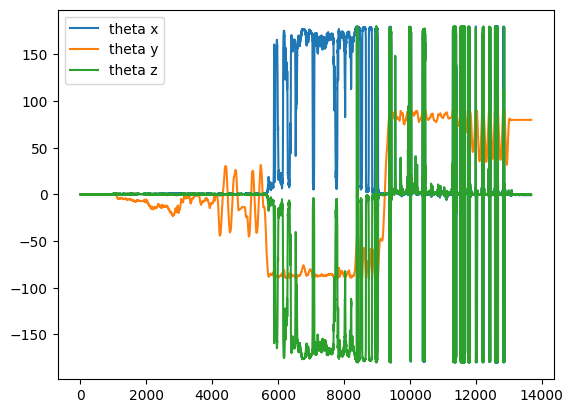

In [104]:
# plt.plot(_theta_x, label="theta x")
plt.plot(_theta_y, label="theta y")
# plt.plot(_theta_z, label="theta z")
plt.legend()

In [99]:
_del_r_0 = []
for i in tqdm(range(len(rmat))):
    _del_r_0.append(rmat[i].T@rmat[0])

# calculating angle for mc
_theta_x_0 = []
_theta_y_0 = []
_theta_z_0 = []

for i in tqdm(_del_r_0):
    _theta_x_0.append(np.arctan2(i[2,1], i[2,2]))
    _theta_y_0.append(np.arctan2(-i[2,0], np.sqrt(i[2,1]**2 + i[2,2]**2)))
    _theta_z_0.append(np.arctan2(i[1,0], i[0,0]))
    
_theta_x_0 = np.array(_theta_x_0)
_theta_y_0 = np.array(_theta_y_0)
_theta_z_0 = np.array(_theta_z_0)

# converting them to degrees
_theta_x_0 = np.rad2deg(_theta_x_0)
_theta_y_0 = np.rad2deg(_theta_y_0)
_theta_z_0 = np.rad2deg(_theta_z_0)
    

100%|██████████| 1322/1322 [00:00<00:00, 527028.79it/s]


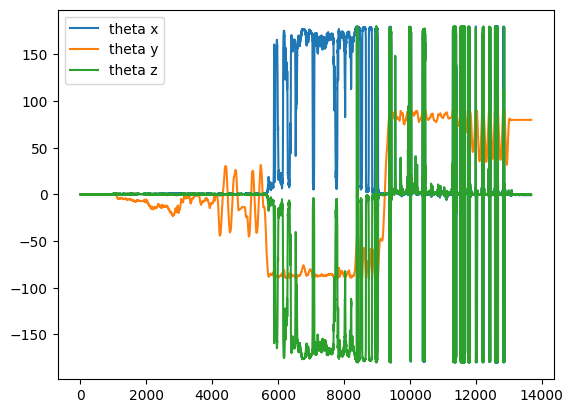

In [103]:
plt.plot(_theta_x, label="theta x")
plt.plot(_theta_y, label="theta y")

plt.plot(_theta_z, label="theta z")
plt.legend()

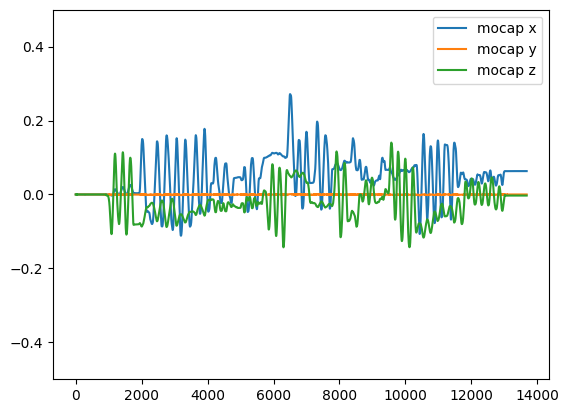

In [40]:
plt.plot(_mc_df["x"], label="mocap x")
plt.plot(_mc_df["y"], label="mocap y")
plt.plot(_mc_df["z"], label="mocap z")
plt.ylim(-0.5, 0.5)
plt.legend()

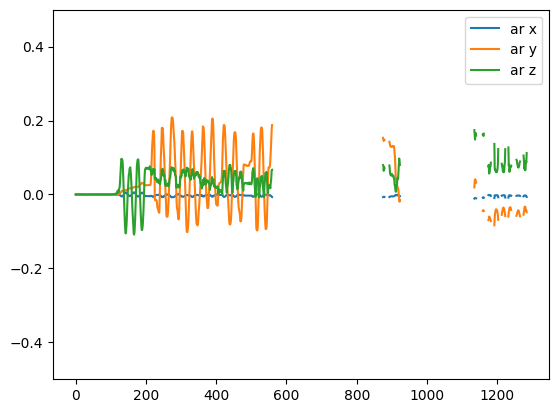

In [41]:
plt.plot(ar_df["x"], label="ar x")
plt.plot(ar_df["y"], label="ar y")
plt.plot(ar_df["z"], label="ar z")
plt.ylim(-0.5, 0.5)
plt.legend()

In [42]:
_mdf = _mocap_df.copy()
_cdf = ar_df.to_pandas()
_cols = []
for i in ["x", "y", "z"]:
    _cols.append(_om[i])
    _cols.append(_xm[i])
    _cols.append(_zm[i])
_cdf["time"] = pd.to_datetime(_cdf["time"])

In [43]:
_mo_df = interpolate_target_df(_mdf, _cdf, _cols)

In [44]:
_mo_df = pl.from_pandas(_mo_df)

In [45]:
_rinpmat = []
for i in tqdm(range(len(_mo_df))):
    
    _x_vec = _mo_df[[_xm["x"], _xm["y"], _xm["z"]]][i, :].to_numpy().T
    _org = _mo_df[[_om["x"], _om["y"], _om["z"]]][i, :].to_numpy().T
    _z_vec = _mo_df[[_zm["x"], _zm["y"], _zm["z"]]][i, :].to_numpy().T

    _rinpmat.append(calculate_rotmat(_x_vec, _z_vec, _org))

100%|██████████| 1321/1321 [00:00<00:00, 2740.40it/s]


In [46]:
#convert time to datetime format    
if type(ar_df["time"][0]) != datetime:
    ar_df = ar_df.with_columns(pl.col("time").str.to_datetime())
if type(ar_df_49["time"][0]) != datetime:
    ar_df_49 = ar_df_49.with_columns(pl.col("time").str.to_datetime())
if type(ar_df_80["time"][0]) != datetime:
    ar_df_80 = ar_df_80.with_columns(pl.col("time").str.to_datetime())

In [47]:
change = (orthormat[0].T @ _mc_pl_df[["x", 'y', 'z']][0].to_numpy().reshape(3,1)) - orthormat[0].T @ ar_df[["x", 'y', 'z']][0].to_numpy().reshape(3,1)
# th_x =  np.arctan2(change[2,1], change[2,2])
# th_y = np.arctan2(-change[2,0], np.sqrt(change[2,1]**2 + change[2,2]**2))
# th_z = np.arctan2(change[1,0], change[0,0])

# print(np.rad2deg(th_x), np.rad2deg(th_y), np.rad2deg(th_z))
print(change)

[[  -0.046391]
 [  -0.007952]
 [   0.086251]]


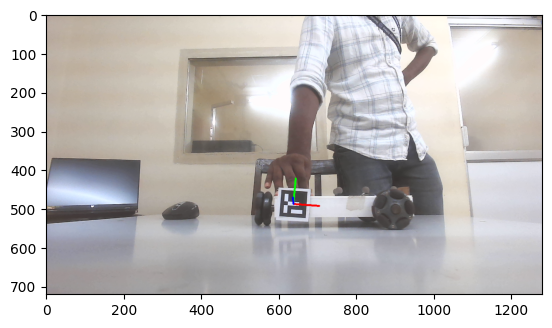

In [48]:
_video_pth = os.path.join(_base_pth,_folder_name,"webcam_color.msgpack")
_video_file = open(_video_pth, "rb")
_video_data = mp.Unpacker(_video_file, object_hook=mpn.decode)

for i in range(800):
    _frame = next(_video_data)
# _frame = next(_video_data)
gray = cv2.cvtColor(_frame, cv2.COLOR_BGR2GRAY)
corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, ARUCO_DICT, parameters=ARUCO_PARAMETERS)

corners, ids, rejectedImgPoints, recoveredIds = aruco.refineDetectedMarkers(
    image = gray,
    board = board,
    detectedCorners = corners,
    detectedIds = ids,
    rejectedCorners = rejectedImgPoints,
    cameraMatrix = _webcam_cam_mat,
    distCoeffs = _webcam_dist)

rotation_vectors, translation_vectors, _ = aruco.estimatePoseSingleMarkers(corners, 0.04, _webcam_cam_mat, _webcam_dist)

cv2.drawFrameAxes(_frame, _webcam_cam_mat, _webcam_dist, rotation_vectors, translation_vectors, 0.04)

_frame = cv2.cvtColor(_frame, cv2.COLOR_BGR2RGB)
plt.imshow(_frame)

Marker 0

In [49]:
offset = np.array([0., 0., 0.]).reshape(3,1)

initial = np.array([0., 0., 0.]).reshape(3,1)

newdata = {"x":[], "y":[], "z":[]}
for i in range(len(ar_df)):
    
    # val = _rinpmat[i].T @ df_0_ml[["x", "y", "z"]][i].to_numpy().reshape(3,1) - 0.1*_rinpmat[i][:,0] - 0.05*_rinpmat[i][:,1] + 0.12*_rinpmat[i][:,2]
    val = (orthormat[i].T @ df_0_ml[["x", "y", "z"]][i].to_numpy().reshape(3,1)) - 0.12*orthormat[i][:,0] - 0.00*orthormat[i][:,1] + 0.02*orthormat[i][:,2]
    # val = rmat[i].T @ df_0_ml[["x", "y", "z"]][i].to_numpy().reshape(3,1)  + 0.1*rmat[i][:,2] + 0.05*rmat[i][:,1] + 0.14*rmat[i][:,0]

    # val = ar_df[["x", "y", "z"]][i].to_numpy().reshape(3,1)
    
    
    if i == 0:
        initial = val
    if val is None:
        rval = np.nan
    else:
        rval = val - offset
        
    

    # reval = (rotMat.T @ (rval - initial)).T[0]
    reval = rotMat.T@ (_ar_lframe_rot.T @ (rval - initial)).T[0]
    # reval = (rval- initial).T[0]

    newdata["x"].append(reval[0])
    newdata["y"].append(reval[1])
    newdata["z"].append(reval[2])

Marker 49

In [50]:
offset = np.array([0., 0., 0.]).reshape(3,1)

initial = np.array([0., 0., 0.]).reshape(3,1)

first_val = np.array([0., 0., 0.]).reshape(3,1)

newdata_49 = {"x":[], "y":[], "z":[]}
for i in range(len(ar_df)):
    
    # val_49 = _rinpmat[i].T @ ar_df[["x", "y", "z"]][i].to_numpy().reshape(3,1) - 0.0*_rinpmat[i][:,0] - 0.00*_rinpmat[i][:,1] + 0.0*_rinpmat[i][:,2]
    # val_49 = (orthormat[i].T @ df_0_ml[["x", "y", "z"]][i].to_numpy().reshape(3,1)) - 0.12*orthormat[i][:,0] - 0.00*orthormat[i][:,1] + 0.02*orthormat[i][:,2]
    # val_49 = rmat[i].T @ df_0_ml[["x", "y", "z"]][i].to_numpy().reshape(3,1)  + 0.1*rmat[i][:,2] + 0.05*rmat[i][:,1] + 0.14*rmat[i][:,0]

    val_49 = ar_df_49[["x", "y", "z"]][i].to_numpy().reshape(3,1)
    
    if i == 0:
        initial = ar_df[["x", "y", "z"]][0].to_numpy().reshape(3,1)
    if val_49 is None:
        rval_49 = np.nan
    else:
        if first_val is np.array([0., 0., 0.]).reshape(3,1):
            first_val = val_49
            
        rval_49 = val_49 - offset

    reval_49 = (rotMat.T @ (rval_49 - first_val)).T[0]

    newdata_49["x"].append(reval_49[0])
    newdata_49["y"].append(reval_49[1])
    newdata_49["z"].append(reval_49[2])

Marker 80

In [51]:
offset = np.array([0., 0., 0.]).reshape(3,1)

initial = np.array([0., 0., 0.]).reshape(3,1)
first_val = np.array([0., 0., 0.]).reshape(3,1)

newdata_80 = {"x":[], "y":[], "z":[]}

diff = ar_df[['x', 'y', 'z']][0].to_numpy().reshape(3,1) - _mc_pl_df[['x', 'y', 'z']][0].to_numpy().reshape(3,1)
for i in range(len(ar_df)):
    
    # val_80 = _rinpmat[i].T @ ar_df[["x", "y", "z"]][i].to_numpy().reshape(3,1) - _rinpmat[i].T @ diff
    # val_80 = (orthormat[i].T @ df_0_ml[["x", "y", "z"]][i].to_numpy().reshape(3,1)) - 0.12*orthormat[i][:,0] - 0.00*orthormat[i][:,1] + 0.02*orthormat[i][:,2]
    # val_80 = rmat[i].T @ df_0_ml[["x", "y", "z"]][i].to_numpy().reshape(3,1)  + 0.1*rmat[i][:,2] + 0.05*rmat[i][:,1] + 0.14*rmat[i][:,0]

    val_80 = ar_df_80[["x", "y", "z"]][i].to_numpy().reshape(3,1)
    
    if i == 0:
        initial = ar_df[["x", "y", "z"]][0].to_numpy().reshape(3,1)
    if val_80 is None:
        rval_80 = np.nan
    else:
        if first_val is np.array([0., 0., 0.]).reshape(3,1):
            first_val = val_80
        rval_80 = val_80 - offset

    reval_80 = (rotMat.T @ (rval_80)).T[0]

    newdata_80["x"].append(reval_80[0])
    newdata_80["y"].append(reval_80[1])
    newdata_80["z"].append(reval_80[2])

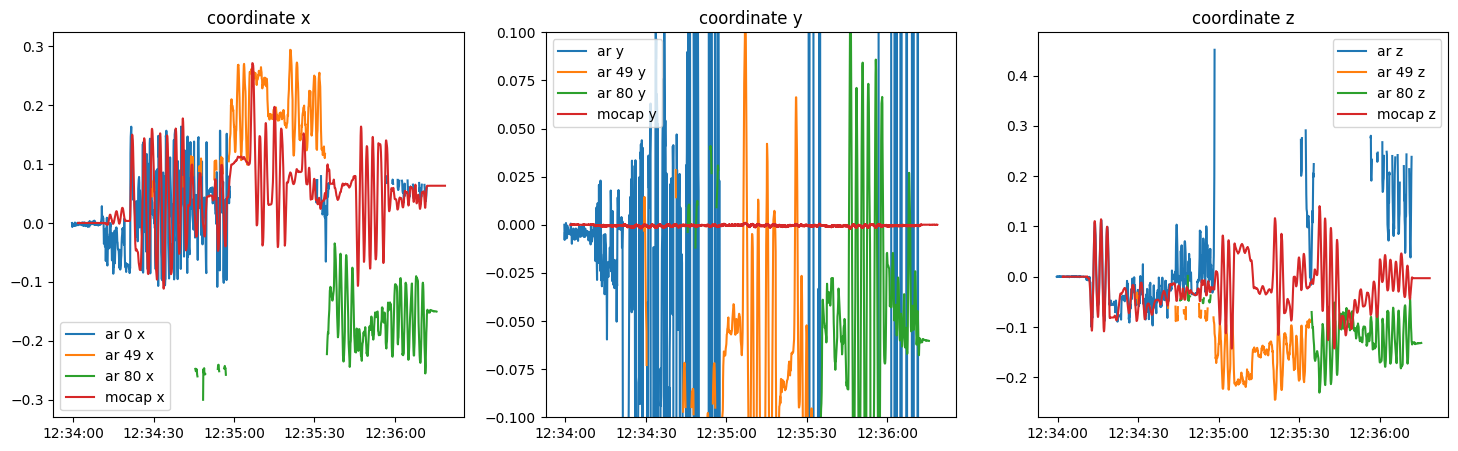

In [52]:

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True,
                                    figsize=(18, 5))

ax0.plot(ar_df["time"],np.array(newdata["x"]), label="ar 0 x")
ax0.plot(ar_df["time"],np.array(newdata_49["x"]) + 0.23, label="ar 49 x")
ax0.plot(ar_df["time"],np.array(newdata_80["x"]) - 0.11, label="ar 80 x")
ax0.plot(_mc_df["time"],_mc_df["x"] - _mc_df["x"][0], label="mocap x")
# ax0.set_ylim(-0.3, 0.3)
ax0.set_title("coordinate x")
ax0.legend()

ax1.plot(ar_df["time"],np.array(newdata["y"]), label="ar y")
ax1.plot(ar_df["time"],np.array(newdata_49["y"]) - 0.028, label="ar 49 y")
ax1.plot(ar_df["time"],-np.array(newdata_80["y"]) + 0.032, label="ar 80 y")
ax1.plot(_mc_df["time"],_mc_df["y"] - _mc_df["y"][0], label="mocap y")


ax1.set_ylim(-0.1, 0.1)
ax1.set_title("coordinate y")
ax1.legend()

ax2.plot(ar_df["time"],np.array(newdata["z"]), label="ar z")
ax2.plot(ar_df["time"],np.array(newdata_49["z"]) - 0.2, label="ar 49 z")
ax2.plot(ar_df["time"],np.array(newdata_80["z"]) - 0.18 , label="ar 80 z")
ax2.plot(_mc_df["time"],_mc_df["z"] - _mc_df["z"][0], label="mocap z")

ax2.set_title("coordinate z")
# ax2.set_ylim(-0.3, 0.3) 

plt.legend()

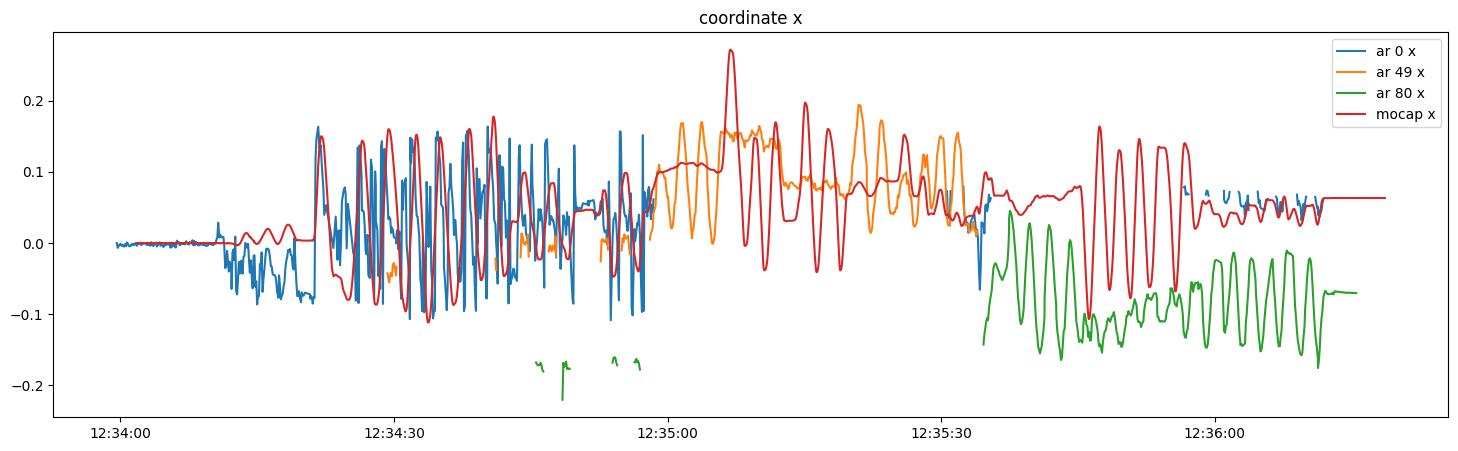

In [53]:
fig, (ax0) = plt.subplots(nrows=1, ncols=1, sharex=True,
                                    figsize=(18, 5))

ax0.plot(ar_df["time"],np.array(newdata["x"]), label="ar 0 x")
ax0.plot(ar_df["time"],np.array(newdata_49["x"]) + 0.13, label="ar 49 x")
ax0.plot(ar_df["time"],np.array(newdata_80["x"]) - 0.03, label="ar 80 x")
ax0.plot(_mc_df["time"],_mc_df["x"] - _mc_df["x"][0], label="mocap x")
# ax0.set_ylim(-0.3, 0.3)
ax0.set_title("coordinate x")
ax0.legend()

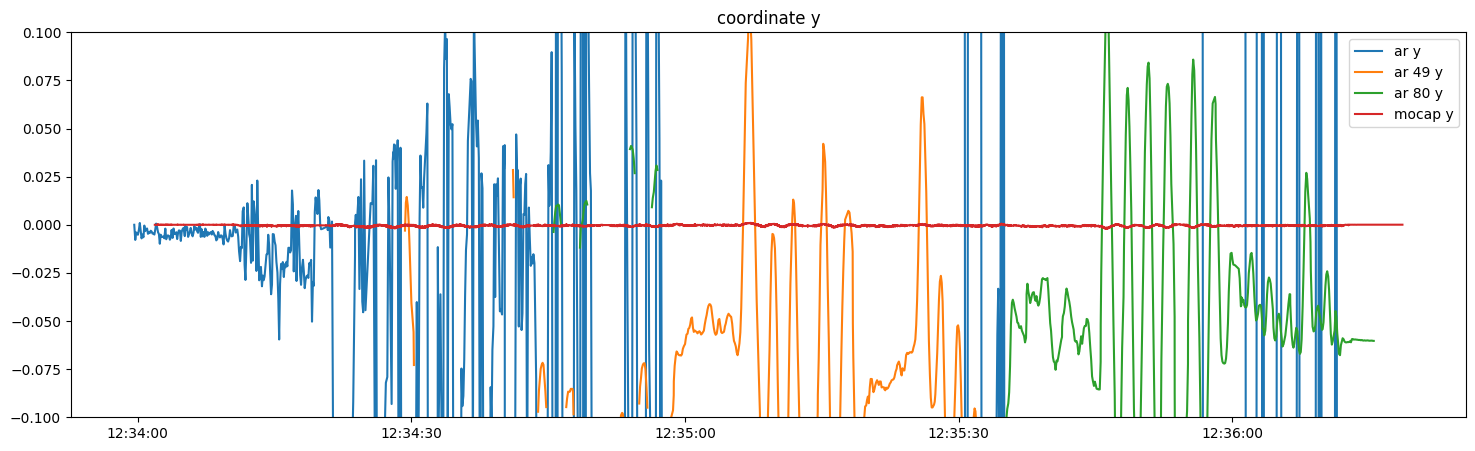

In [54]:
fig, (ax0) = plt.subplots(nrows=1, ncols=1, sharex=True,
                                    figsize=(18, 5))

ax0.plot(ar_df["time"],np.array(newdata["y"]), label="ar y")
ax0.plot(ar_df["time"],np.array(newdata_49["y"]) - 0.028, label="ar 49 y")
ax0.plot(ar_df["time"],-np.array(newdata_80["y"]) + 0.032, label="ar 80 y")
ax0.plot(_mc_df["time"],_mc_df["y"] - _mc_df["y"][0], label="mocap y")
ax0.set_ylim(-0.1, 0.1)
ax0.set_title("coordinate y")
ax0.legend()

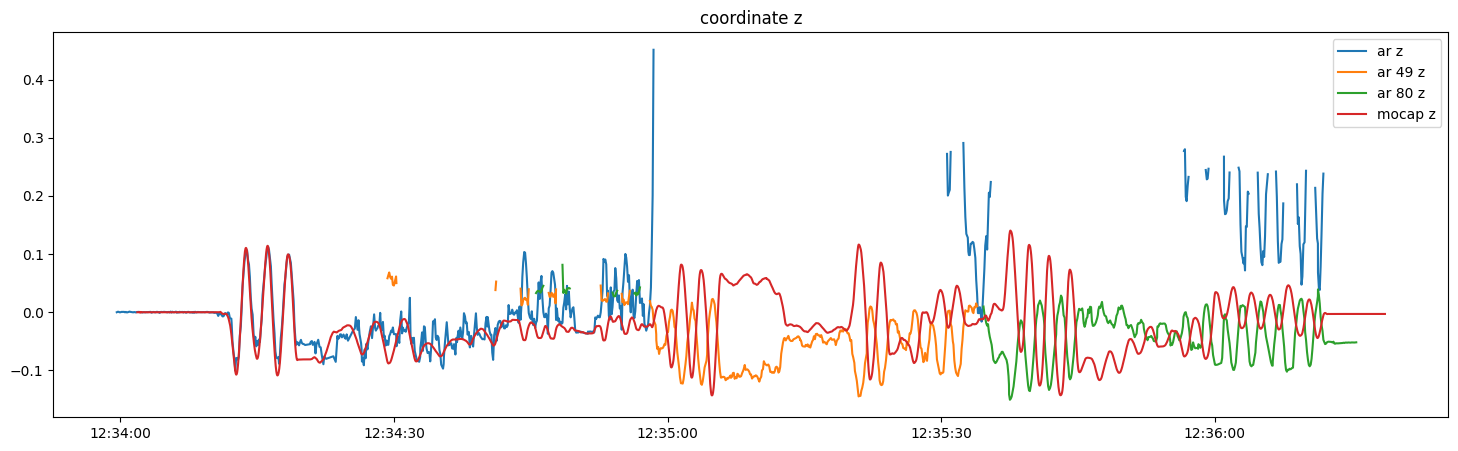

In [55]:
fig, (ax0) = plt.subplots(nrows=1, ncols=1, sharex=True,
                                    figsize=(18, 5))

ax0.plot(ar_df["time"],np.array(newdata["z"]), label="ar z")
ax0.plot(ar_df["time"],np.array(newdata_49["z"]) - 0.1, label="ar 49 z")
ax0.plot(ar_df["time"],np.array(newdata_80["z"]) - 0.1 , label="ar 80 z")
ax0.plot(_mc_df["time"],_mc_df["z"] - _mc_df["z"][0], label="mocap z")

ax0.set_title("coordinate z")
ax0.legend()

In [56]:
offset = np.array([0., 0., 0.]).reshape(3,1)

initial = np.array([0., 0., 0.]).reshape(3,1)

newdata_mc = {"x":[], "y":[], "z":[]}
for i in range(len(_m_df)):
 
    val = _m_df[[_zm["x"], _zm["y"], _zm["z"]]][i].to_numpy().reshape(3,1)
    
    if i == 0:
        initial = val
    if val is None:
        rval = np.nan
    else:
        rval = val - offset

    # reval = (rotMat.T @ (rmat[0].T@(rval - initial))).T[0]
    reval = (rotMat.T @ (rval - initial)).T[0]
    # reval = (rval- initial).T[0]

    newdata_mc["x"].append(reval[0])
    newdata_mc["y"].append(reval[1])
    newdata_mc["z"].append(reval[2])

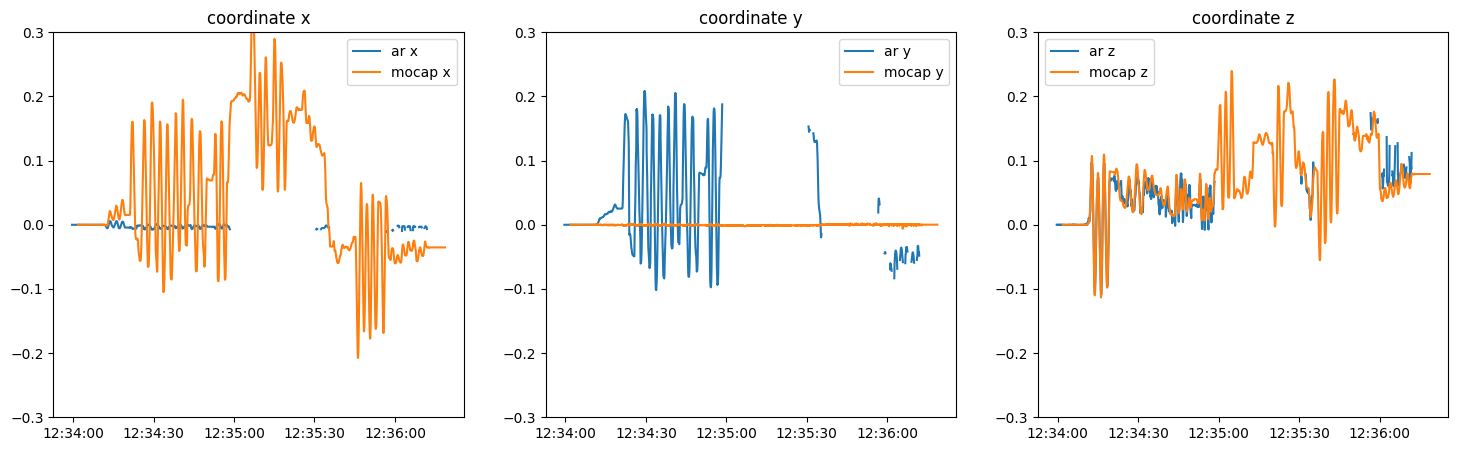

In [57]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True,
                                    figsize=(18, 5))

ax0.plot(ar_df["time"], ar_df["x"], label="ar x")
ax0.plot(_m_df["time"], np.array(newdata_mc["x"]), label="mocap x")
ax0.set_ylim(-0.3, 0.3)
ax0.set_title("coordinate x")
ax0.legend()

ax1.plot(ar_df["time"], ar_df["y"], label="ar y")
ax1.plot(_m_df["time"], - np.array(newdata_mc["y"]), label="mocap y")
ax1.set_ylim(-0.3, 0.3)
ax1.set_title("coordinate y")
ax1.legend()

ax2.plot(ar_df["time"], ar_df["z"], label="ar z")
ax2.plot(_m_df["time"], -np.array(newdata_mc["z"]), label="mocap z")
ax2.set_title("coordinate z")
ax2.set_ylim(-0.3, 0.3)


plt.legend()